In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import Callback
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from nltk.probability import FreqDist
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [ ]:
!wget https://s3-us-west-2.amazonaws.com/allennlp/datasets/glove/glove.840B.300d.txt.gz
!gunzip -k glove.840B.300d.txt.gz

In [0]:
data = pd.read_csv('../hm_train_cleaned.csv', header=None)

In [4]:
data.head()

,0,1,2
0,27673,I went on a successful date with someone I fel...,affection
1,27674,I was happy when my son got 90 % marks in his ...,affection
2,27675,I went to the gym this morning and did yoga .,exercise
3,27676,We had a serious talk with some friends of our...,bonding
4,27677,I went with grandchildren to butterfly display...,affection


#### Make a list af all tokens in the data

In [0]:
all_tokens = [token.lower() for i in data.index for token in data.loc[i, 1].split()]

#### Compute frequency counts of the tokens

In [0]:
freq = dict(FreqDist(all_tokens))

In [7]:
word_counts = sorted(freq.values(), reverse=True)
print('Total no. of unique tokens:', len(word_counts))

Total no. of unique tokens: 23273


#### Calculate the percentage of tokens that will be included if we only consider top NUM_WORDS most frequently occurring tokens


In [8]:
NUM_WORDS = 15000
print('Percentage of tokens included:', \
      sum(word_counts[:NUM_WORDS])/sum(word_counts)*100)

Percentage of tokens included: 99.33180412079702


#### Tokenize the data and make sequences containing the word ids

In [0]:
tokenizer = Tokenizer(num_words=NUM_WORDS, filters='')
tokenizer.fit_on_texts(data[1])
sequences = tokenizer.texts_to_sequences(data[1])
word_index = tokenizer.word_index

#### Some statistics of the sequence length

In [10]:
lengths = np.asarray([len(s) for s in sequences])
print('Mean length of sequence:', np.mean(lengths))
print('Std. Dev. of length:', np.std(lengths))
MAX_LEN = 100
print('Percentage of sequences with length less than MAX_LEN:',\
      np.mean(lengths<MAX_LEN)*100)

Mean length of sequence: 20.38818985096401
Std. Dev. of length: 23.63174092540852
Percentage of sequences with length less than MAX_LEN: 98.99040135276273


#### Pad the sequences upto MAX_LEN length and one-hot encode labels

In [11]:
X = pad_sequences(sequences, maxlen=MAX_LEN)

# Encode to string valued labels into integers
LE = LabelEncoder()
LE.fit(data[2])

# Convert the integer labels to one-hot
labels = to_categorical(LE.transform(data[2]))

print('X.shape = %s \t labels.shape = %s'%(str(X.shape), str(labels.shape)))

X.shape = (60321, 100) 	 labels.shape = (60321, 7)


#### Do a train-test split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=5000)
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_yest:', y_test.shape)

Shape of X_train: (55321, 100)
Shape of X_test: (5000, 100)
Shape of y_train: (55321, 7)
Shape of y_yest: (5000, 7)


#### Load GloVe word embeddings

In [14]:
embeddings = {}
EMBEDDING_DIM = 300
with open('glove.840B.300d.txt', encoding='utf8') as f:
    for line in f:
        line = line.split(' ')
        word = line[0]
        vector = np.asarray(line[1:], dtype='float32')
        assert len(vector) == EMBEDDING_DIM
        embeddings[word] = vector
print('Size of vocab: %d'%len(embeddings))

Size of vocab: 2196016


#### Using the embedding dictionary to compute the embedding matrix

In [0]:
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    vector = embeddings.get(word)
    if vector is not None:
        embedding_matrix[i] = vector
del embeddings # Free some memory

#### Initialize the embedding layer

In [0]:
embedding_layer = Embedding(len(word_index) + 1,\
                            EMBEDDING_DIM,\
                            weights=[embedding_matrix],\
                            input_length=MAX_LEN,\
                            trainable=False)

In [0]:
cp = ModelCheckpoint('model_cnn.hdf5', monitor='val_loss',\
                     verbose=1, save_best_only=True)

#### Build the model - 3 Conv layers with dropout in between + 2 Dense layers

In [18]:
model = Sequential()
model.add(embedding_layer)
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='softmax'))

opt = Adam(1e-3)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          6982200   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           192128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 96, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 128)           82048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 92, 128)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 88, 128)           82048     
_________________________________________________________________
dropout_3 (Dropout)          (None, 88, 128)           0         
__________

#### Train the model

In [19]:
# Weighted cross-entropy loss to handle class imbalance
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=20, batch_size=32, callbacks=[cp],\
                    class_weight='auto') 

Train on 55321 samples, validate on 5000 samples
Epoch 1/20
55321/55321 [==============================] - 25s 458us/step - loss: 0.7170 - acc: 0.7543 - val_loss: 0.5027 - val_acc: 0.8356

Epoch 00001: val_loss improved from inf to 0.50269, saving model to model_cnn.hdf5
Epoch 2/20
55321/55321 [==============================] - 22s 397us/step - loss: 0.5129 - acc: 0.8270 - val_loss: 0.4360 - val_acc: 0.8520

Epoch 00002: val_loss improved from 0.50269 to 0.43601, saving model to model_cnn.hdf5
Epoch 3/20
55321/55321 [==============================] - 22s 405us/step - loss: 0.4566 - acc: 0.8435 - val_loss: 0.4258 - val_acc: 0.8474

Epoch 00003: val_loss improved from 0.43601 to 0.42584, saving model to model_cnn.hdf5
Epoch 4/20
55321/55321 [==============================] - 22s 396us/step - loss: 0.4275 - acc: 0.8520 - val_loss: 0.4116 - val_acc: 0.8568

Epoch 00004: val_loss improved from 0.42584 to 0.41157, saving model to model_cnn.hdf5
Epoch 5/20
55321/55321 [=======================

#### Plot the loss and accuracy w.r.t. the no. of epochs

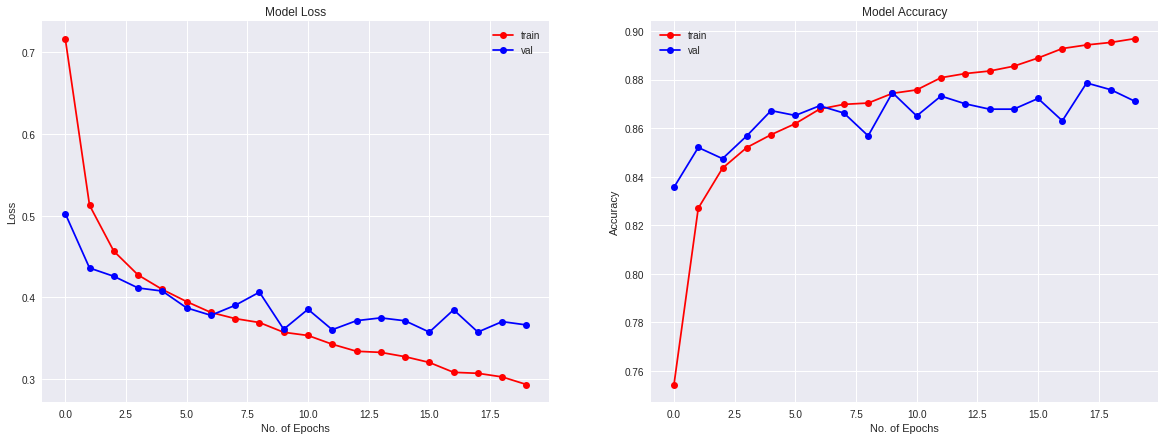

In [20]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'ro-', label='train')
plt.plot(history.history['val_loss'], 'bo-', label='val')
plt.xlabel('No. of Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['acc'], 'ro-',label='train')
plt.plot(history.history['val_acc'], 'bo-', label='val')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

#### Predict and compute the F1 Score on the validation set 

In [0]:
model.load_weights('model_cnn.hdf5')
probs = model.predict(X_test)
y_pred = np.zeros(probs.shape)
y_pred[range(y_pred.shape[0]), np.argmax(probs, axis=1)] = 1

In [22]:
print('Validation F1 Score:', f1_score(y_test, y_pred, average='weighted'))

Validation F1 Score: 0.8712862938145656


### Predict on the test set

#### Read test data

In [23]:
hm_test = pd.read_csv('../hm_test_cleaned.csv', header=None)
hm_test.head()

,0,1
0,88305,I spent the weekend in Chicago with my friends .
1,88306,We moved back into our house after a remodel ....
2,88307,My fiance proposed to me in front of my family...
3,88308,I ate lobster at a fancy restaurant with some ...
4,88309,I went out to a nice restaurant on a date with...


#### Tokenize and pad test sequences

In [0]:
test_sequences = tokenizer.texts_to_sequences(hm_test[1])
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN)

#### Make predictions

In [25]:
test_prob = model.predict(test_padded)
test_prob[:5]

array([[3.6593283e-05, 4.1339194e-05, 9.9992180e-01, 8.1322241e-08,
        1.7777780e-09, 8.9940343e-08, 2.8467471e-11],
       [7.3487067e-01, 4.7105186e-02, 4.1138060e-02, 1.6860431e-01,
        1.7630167e-03, 5.2343700e-03, 1.2843835e-03],
       [2.4857809e-04, 9.9965060e-01, 7.3486546e-05, 5.1780671e-07,
        2.5885562e-05, 9.6694384e-07, 1.5188916e-09],
       [2.2064896e-05, 2.1208394e-05, 9.9995303e-01, 3.6060890e-06,
        4.3562698e-10, 1.7687893e-07, 1.5465298e-10],
       [6.3877160e-15, 9.5437631e-02, 8.9681745e-01, 7.7449153e-03,
        2.4186935e-22, 1.3153457e-09, 4.2678885e-19]], dtype=float32)

#### Convert probablities into integer labels

In [26]:
test_pred = np.argmax(test_prob, axis=1)
test_pred[:5]

array([2, 0, 1, 2, 2])

#### Convert the integer lables into the corresponding string targets

In [27]:
test_classes = LE.inverse_transform(test_pred)
test_classes[:5]

array(['bonding', 'achievement', 'affection', 'bonding', 'bonding'],
      dtype=object)

#### Make submission dataframe

In [28]:
submit = hm_test.copy()
submit[1] = test_classes
submit.columns = ['hmid', 'predicted_category']
submit.head()

,hmid,predicted_category
0,88305,bonding
1,88306,achievement
2,88307,affection
3,88308,bonding
4,88309,bonding


#### Write to submission.csv

In [0]:
submit.to_csv('submission.csv', index=None)